In [12]:
import pandas as pd
from pathlib import Path
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import linkage, leaves_list
from pykalman import KalmanFilter
import statsmodels.tsa.api as tsa

## Configuration

In [13]:
tic_filename = Path('data/nasdaq_index_list_filtered.csv')
yf_filename = os.path.abspath('data/ohlcv/{}.csv')
tickers = pd.read_csv(tic_filename)
tickers = tickers['0'].tolist()

## Time series smoothing techniques - based on the Apple stock close price

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


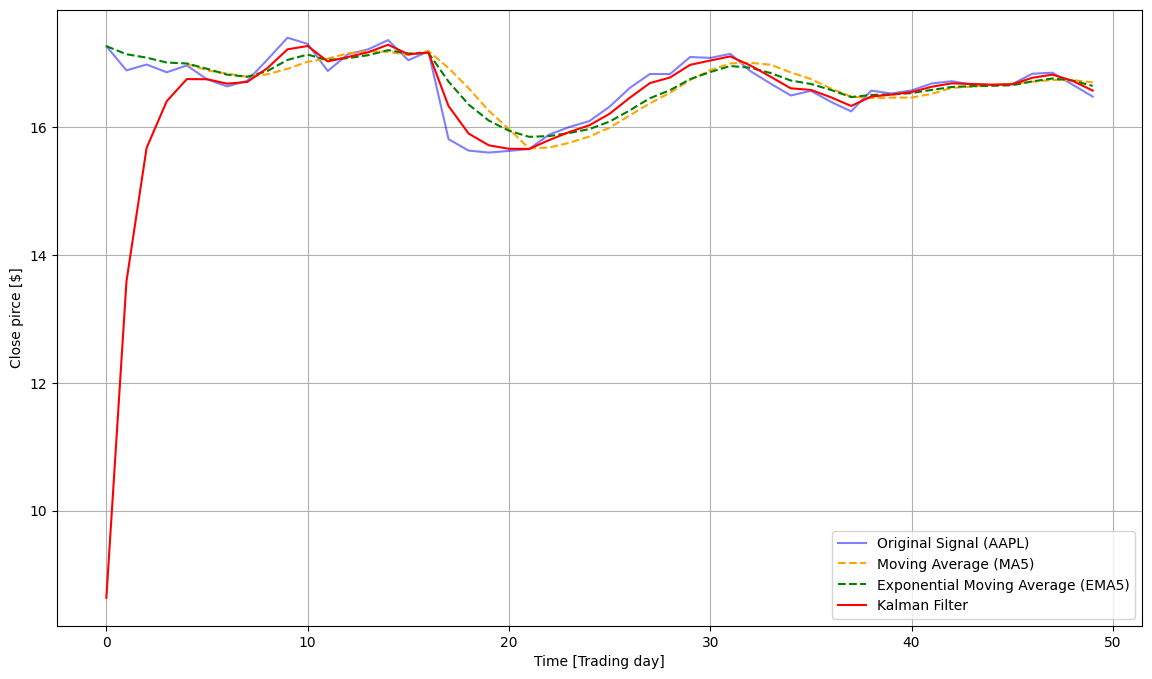

In [14]:
aapl = pd.read_csv(yf_filename.format('AAPL')).iloc[0:50]
aapl['MA5'] = aapl['Close'].rolling(window=5).mean()
aapl['EMA5'] = aapl['Close'].ewm(span=5, adjust=False).mean()
kf = KalmanFilter(initial_state_mean=0, n_dim_obs=1)
state_means, _ = kf.filter(aapl['Close'].values)
aapl['kalman'] = state_means
plt.figure(figsize=(14, 8))
plt.plot(aapl.index, aapl['Close'], label='Original Signal (AAPL)', color='blue', alpha=0.5)
plt.plot(aapl.index, aapl['MA5'], label='Moving Average (MA5)', color='orange', linestyle='--')
plt.plot(aapl.index, aapl['EMA5'], label='Exponential Moving Average (EMA5)', color='green', linestyle='--')
plt.plot(aapl.index, aapl['kalman'], label='Kalman Filter', color='red')
plt.xlabel('Time [Trading day]')
plt.ylabel('Close pirce [$]')
plt.legend()
plt.grid(True)
plt.savefig('charts/aapl_smoothing.eps', format='eps', dpi=300, bbox_inches='tight')
plt.show()

## Example of time series decomposition based on the Apple stock

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


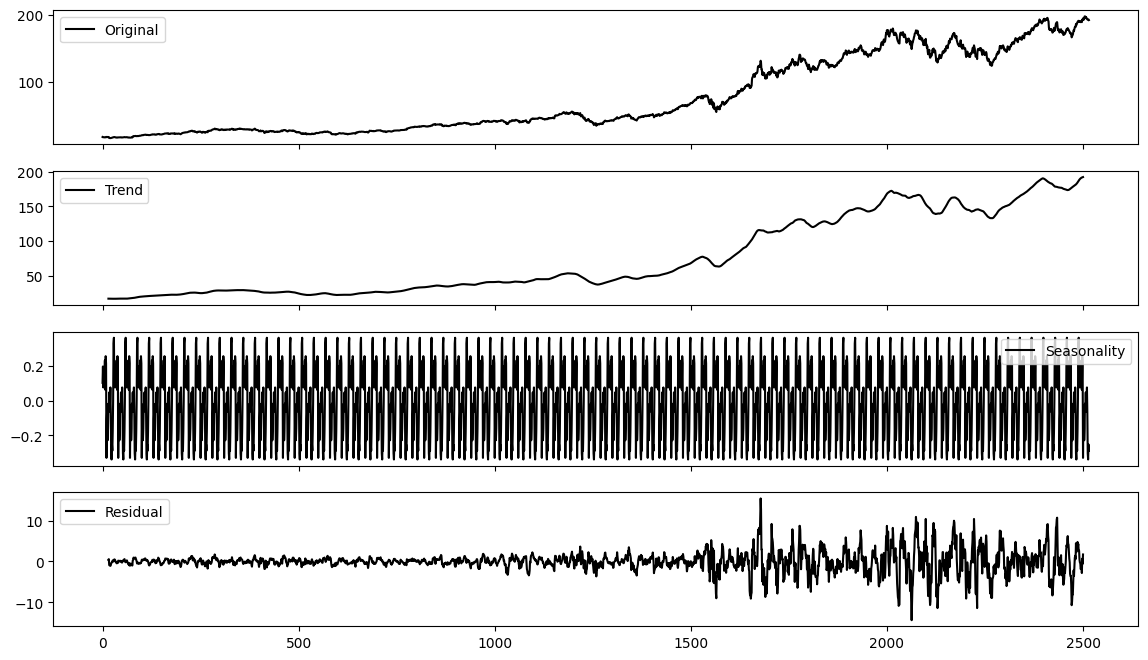

In [15]:
aapl = pd.read_csv(yf_filename.format('AAPL'))

# Decompose the time series of close prices
components = tsa.seasonal_decompose(aapl['Close'], model='additive', period=30)

# Combine original data with its decomposed components
ts = (aapl['Close'].to_frame('Original')
      .assign(Trend=components.trend)
      .assign(Seasonality=components.seasonal)
      .assign(Residual=components.resid))
ts.plot(subplots=True, figsize=(14, 8), color='black')
plt.savefig('charts/time_series_decomposition.eps', format='eps', dpi=300, bbox_inches='tight')
plt.show()

## 

## Estimation of reasonable stop levels available for the DRL agent

In [16]:

df = pd.DataFrame()
for s in tickers:
    df = pd.concat([df, pd.read_csv(yf_filename.format(s))])
ol_diffs = (df['Open'] - df['Low']) / df['Open']
'Mean of price drops from open to low [%]', ol_diffs.mean() * 100, \
'Median of price drops from open to low [%]', ol_diffs.median() * 100

('Mean of price drops from open to low [%]',
 1.2662816319266694,
 'Median of price drops from open to low [%]',
 0.8811516401641021)

The figure below picutres density distribution for day-to-day Close price change. 
Density is calculated using Kernel Density Estimation.

Text(0, 0.5, 'Density')

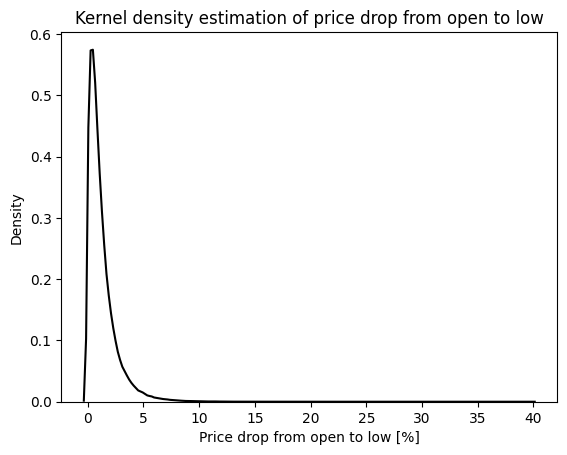

In [17]:
sns.kdeplot(ol_diffs * 100, color='black', fill=False)
plt.xlabel('Price drop from open to low [%]')
plt.title('Kernel density estimation of price drop from open to low')
plt.ylabel('Density')

## Combined data statistics

In [18]:
df = pd.DataFrame()
for ticker in tickers:
    df = pd.concat([df, pd.read_csv(yf_filename.format(ticker), index_col='Date')], ignore_index=True)
with open('tables/describe_data.tex', 'w') as file:
    file.write(df.describe().round(2).to_latex(float_format="%.2f"))
df.describe().round(2)

,Open,High,Low,Close,Volume
count,232385.00,232385.00,232385.00,232385.00,2.323850e+05
mean,145.08,146.95,143.19,145.11,1.077098e+07
std,236.54,239.51,233.54,236.55,2.589277e+07
min,1.62,1.69,1.61,1.62,6.670000e+04
25%,37.73,38.16,37.30,37.74,1.442000e+06
50%,75.60,76.48,74.71,75.64,3.047800e+06
75%,162.63,164.76,160.57,162.73,7.864800e+06
max,3571.48,3571.48,3531.14,3557.55,1.065523e+09


## Data feature correlations

In [19]:
with open('tables/data_corr.tex', 'w') as file:
    file.write(df.corr().to_latex())
df.corr()

,Open,High,Low,Close,Volume
Open,1.000000,0.999897,0.999882,0.999782,-0.120671
High,0.999897,1.000000,0.999840,0.999891,-0.120218
Low,0.999882,0.999840,1.000000,0.999898,-0.121178
Close,0.999782,0.999891,0.999898,1.000000,-0.120698
Volume,-0.120671,-0.120218,-0.121178,-0.120698,1.000000


## NASDAQ-100 assets daily returns correlation matrix sorted with hierarchical clustering

/var/folders/sb/79789zy563v6nhrx5w9xvvtd5cx4x1/T/ipykernel_99076/4053228071.py:5: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = returns.pct_change()
/var/folders/sb/79789zy563v6nhrx5w9xvvtd5cx4x1/T/ipykernel_99076/4053228071.py:8: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = linkage(distance_matrix, method='average')


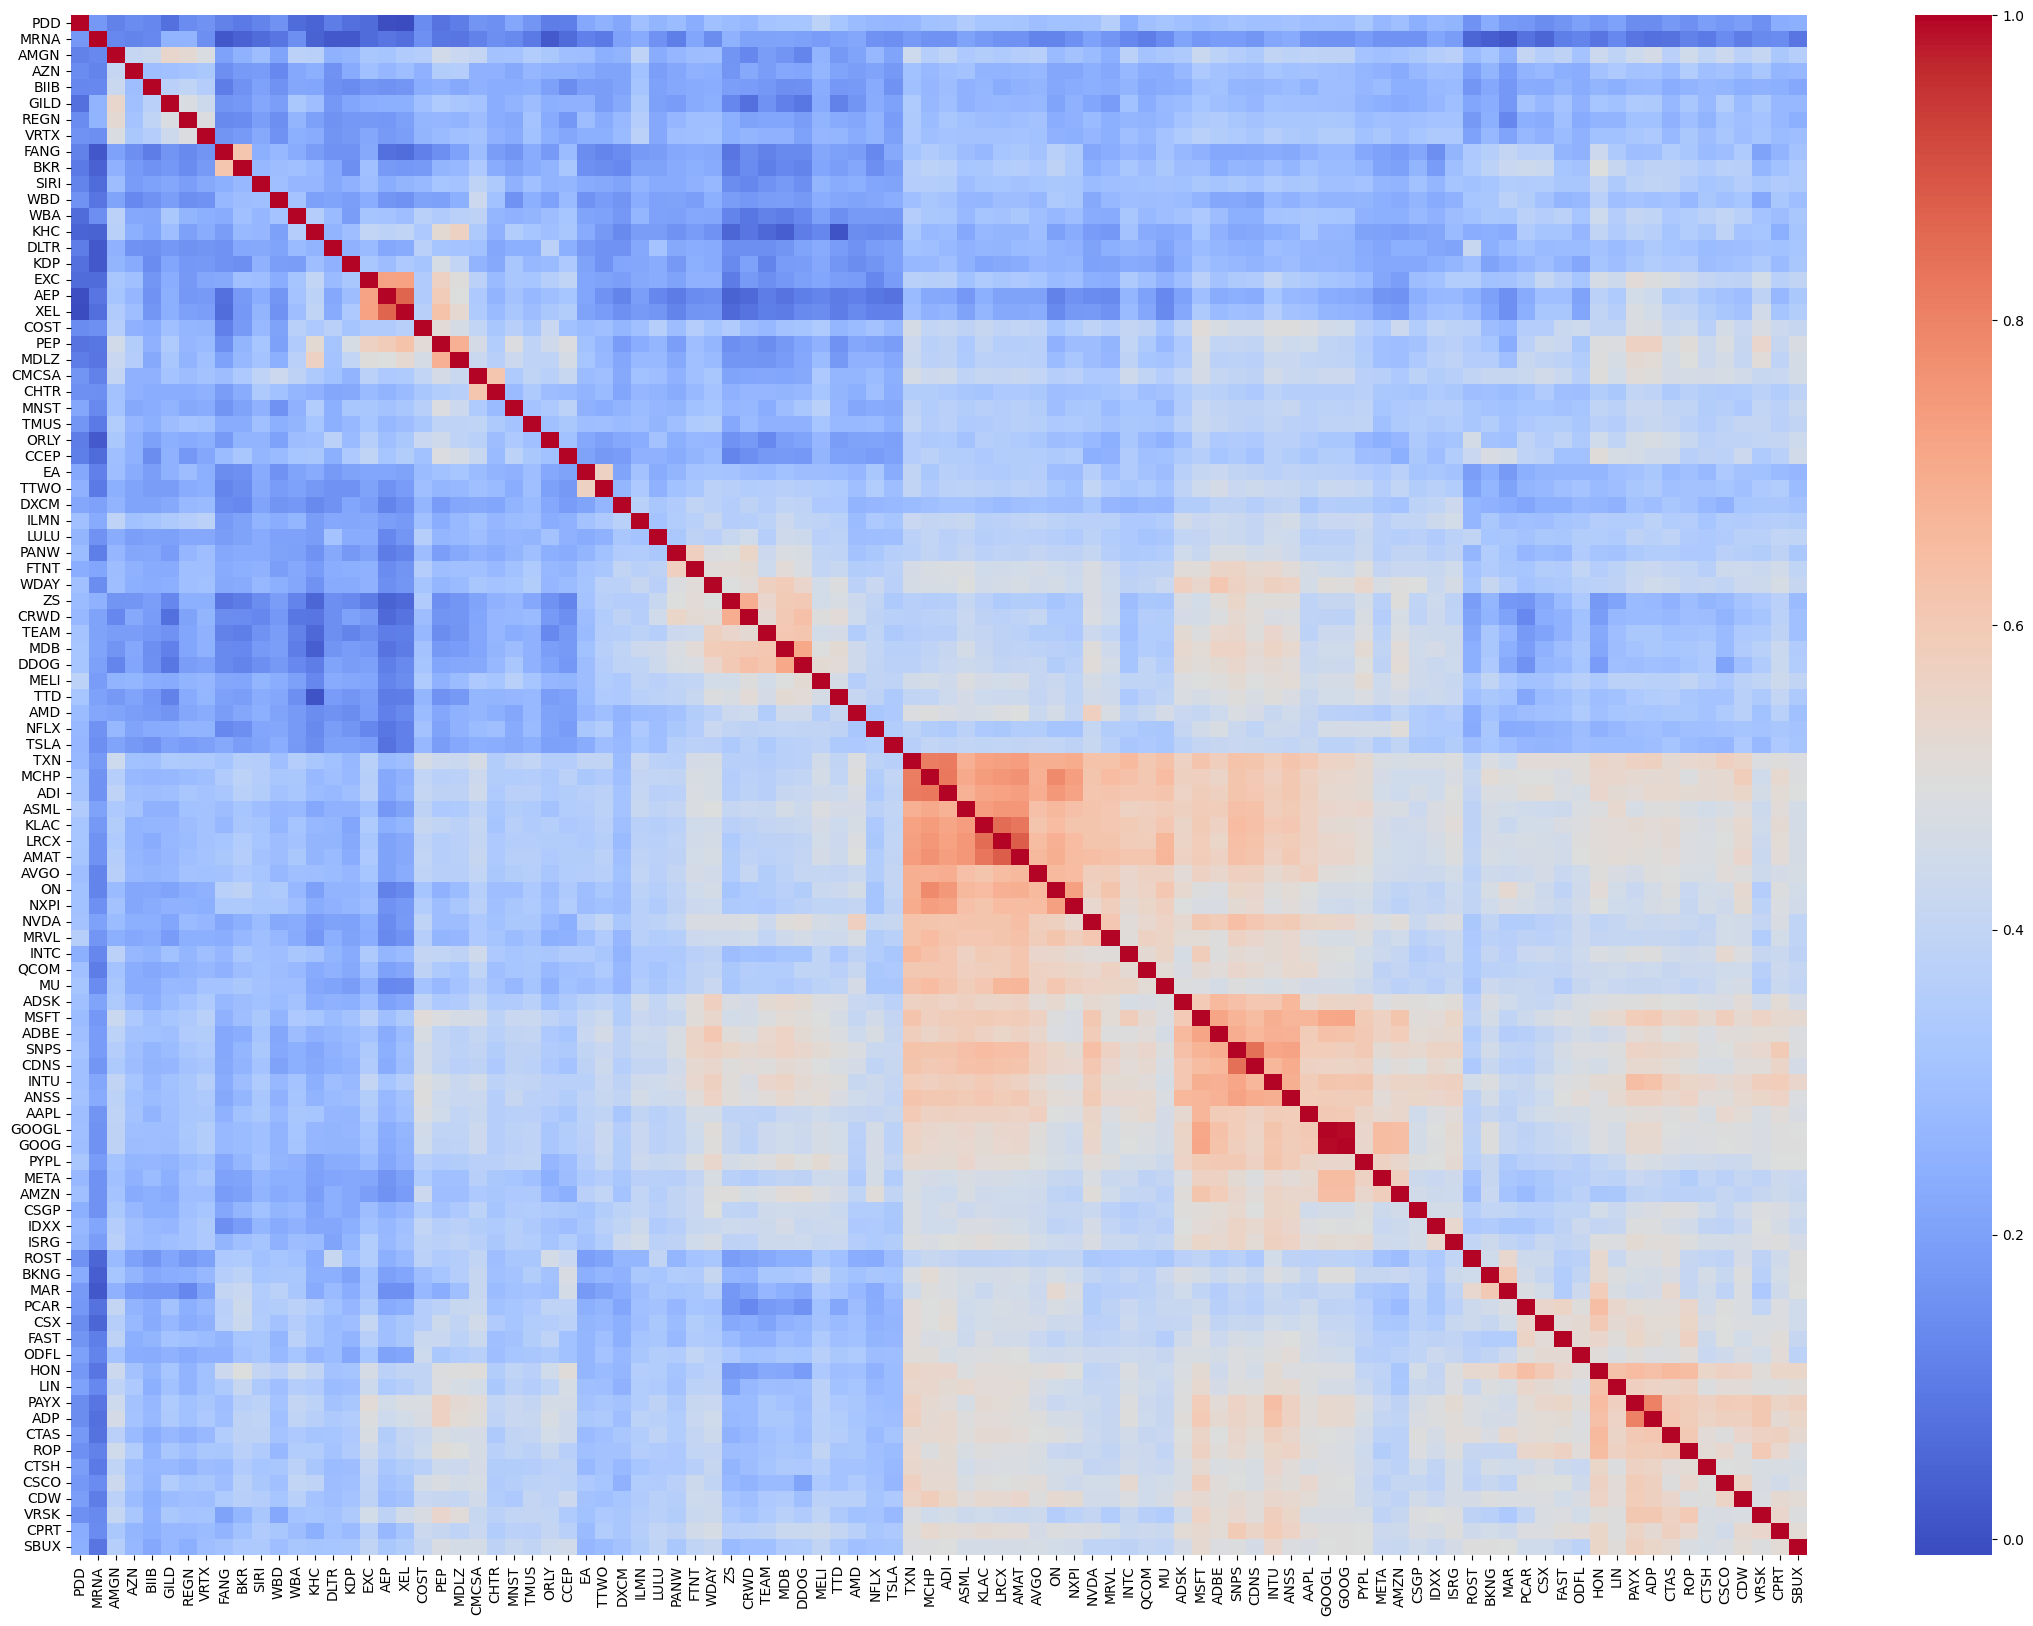

In [20]:
returns = pd.DataFrame(columns=tickers)

for ticker in tickers:
    returns[ticker] = pd.read_csv(yf_filename.format(ticker), index_col='Date', parse_dates=True)['Close']
returns = returns.pct_change()
correlation_matrix = returns.corr()
distance_matrix = 1 - correlation_matrix
linkage_matrix = linkage(distance_matrix, method='average')
sorted_index = leaves_list(linkage_matrix)
sorted_correlation_matrix = correlation_matrix.iloc[sorted_index, sorted_index]
plt.figure(figsize=(28, 20))
sns.heatmap(sorted_correlation_matrix, annot=False, cmap='coolwarm')
plt.savefig('charts/corr_heatmap.eps', format='eps', dpi=50, bbox_inches='tight')
plt.show()